# Perspective: Evaluate Images

Use trained networks for perspective to evaluate test images.

Plot Confusion Matrix and GradCam images.

## Imports and Path definitions

In [1]:
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

import cv2
import pandas as pd
import csv

import tensorflow as tf
from tensorflow.keras import datasets, models

from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing import image

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import time
import seaborn as sns

import numpy as np

%matplotlib inline
tf.__version__

'2.3.0'

### Define paths, adjust to your environment

In [2]:
# define neccessary directories
current_dir = Path().resolve()
project_dir = Path(current_dir).parent

data_dir = os.path.join(project_dir, 'data')
images_dir = os.path.join(data_dir, 'images')

models_dir = os.path.join(project_dir, 'models')

# print(f'project dir = {project_dir}')
# print(f'data dir    = {data_dir}')
# print(f'images dir  = {images_dir}')
# print(f'images dir  = {models_dir}')

In [3]:
# define directory of source files and add its path to sys.path as first entry
src_dir = os.path.join(project_dir, 'src')

# print(src_dir)

sys.path.insert(0, src_dir)

In [4]:
# import all functions needed from the source files
%load_ext autoreload
%autoreload 2
import evaluate as ev
import cnn_helper as hp

## Evaluate all images from a folder with the selected model and plot gradCAM images of them

### Define the pretrained model to use

In [5]:
# model trained for perspective 
model_name = 'perspective_augment_160replace_epoch100_100acc_98acc.h5'
model_path = os.path.join(models_dir, model_name)
model_path

'/Users/norbiorb/Data/git/propulsion/FinalProject/floydhub/mri-classifier/models/perspective_augment_160replace_epoch100_100acc_98acc.h5'

In [6]:
model =  tf.keras.models.load_model(model_path)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


### Label type configuration for evaluation

In [8]:
# label_type (perspective) and labels
label_type = 'perspective'
labels = ['AX', 'COR', 'SAG']

### Evaluate test data

By default the test data images are stored in `perspective_df_test.csv`, respective `sequence_df_test.csv` in the notebooks directory.

In [9]:
csv_path = os.path.join(current_dir, 'perspective_df_test.csv')
# csv_path

In [10]:
#csv_path = os.path.join(test_images_dir, 'df_test.csv')
test_df = pd.read_csv(csv_path, index_col=[0])
print(f'test_df shape: {test_df.shape}')
test_df.head()

test_df shape: (41, 7)


,patient-id,perspective,sequence,perspective-sequence,labels,image-number,image-name
172,TCGA020106,AX,T2,AX-T2,"['AX', 'T2']",1,AX_T2_Glioma_GBM_TCGA020106_1.jpg
137,TCGA061084,AX,T1,AX-T1,"['AX', 'T1']",1,AX_T1_Glioma_GBM_TCGA061084_1.jpg
126,TCGA020087,AX,T1,AX-T1,"['AX', 'T1']",1,AX_T1_Glioma_GBM_TCGA020087_1.jpg
94,TCGA060121,AX,T1KM,AX-T1KM,"['AX', 'T1KM']",1,AX_T1KM_Glioma_GBM_TCGA060121_1.jpg
72,TCGA060119,AX,PWI,AX-PWI,"['AX', 'PWI']",1,AX_PWI_Glioma_GBM_TCGA060119_1.jpg


## Confusion Matrix

Print metrics and plot confusion matrix

In [11]:
test_df['y_true'] = test_df[label_type]
test_df = ev.get_predictions(model, test_df, labels, images_dir)
ev.print_metrics(test_df, labels)

Found 41 validated image filenames belonging to 3 classes.
2/2 [==============================] - 0s 246ms/step


Metrics


,accuracy,f1_macro,f1_micro,precision_macro,precision_micro,recall_macro,recall_micro
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


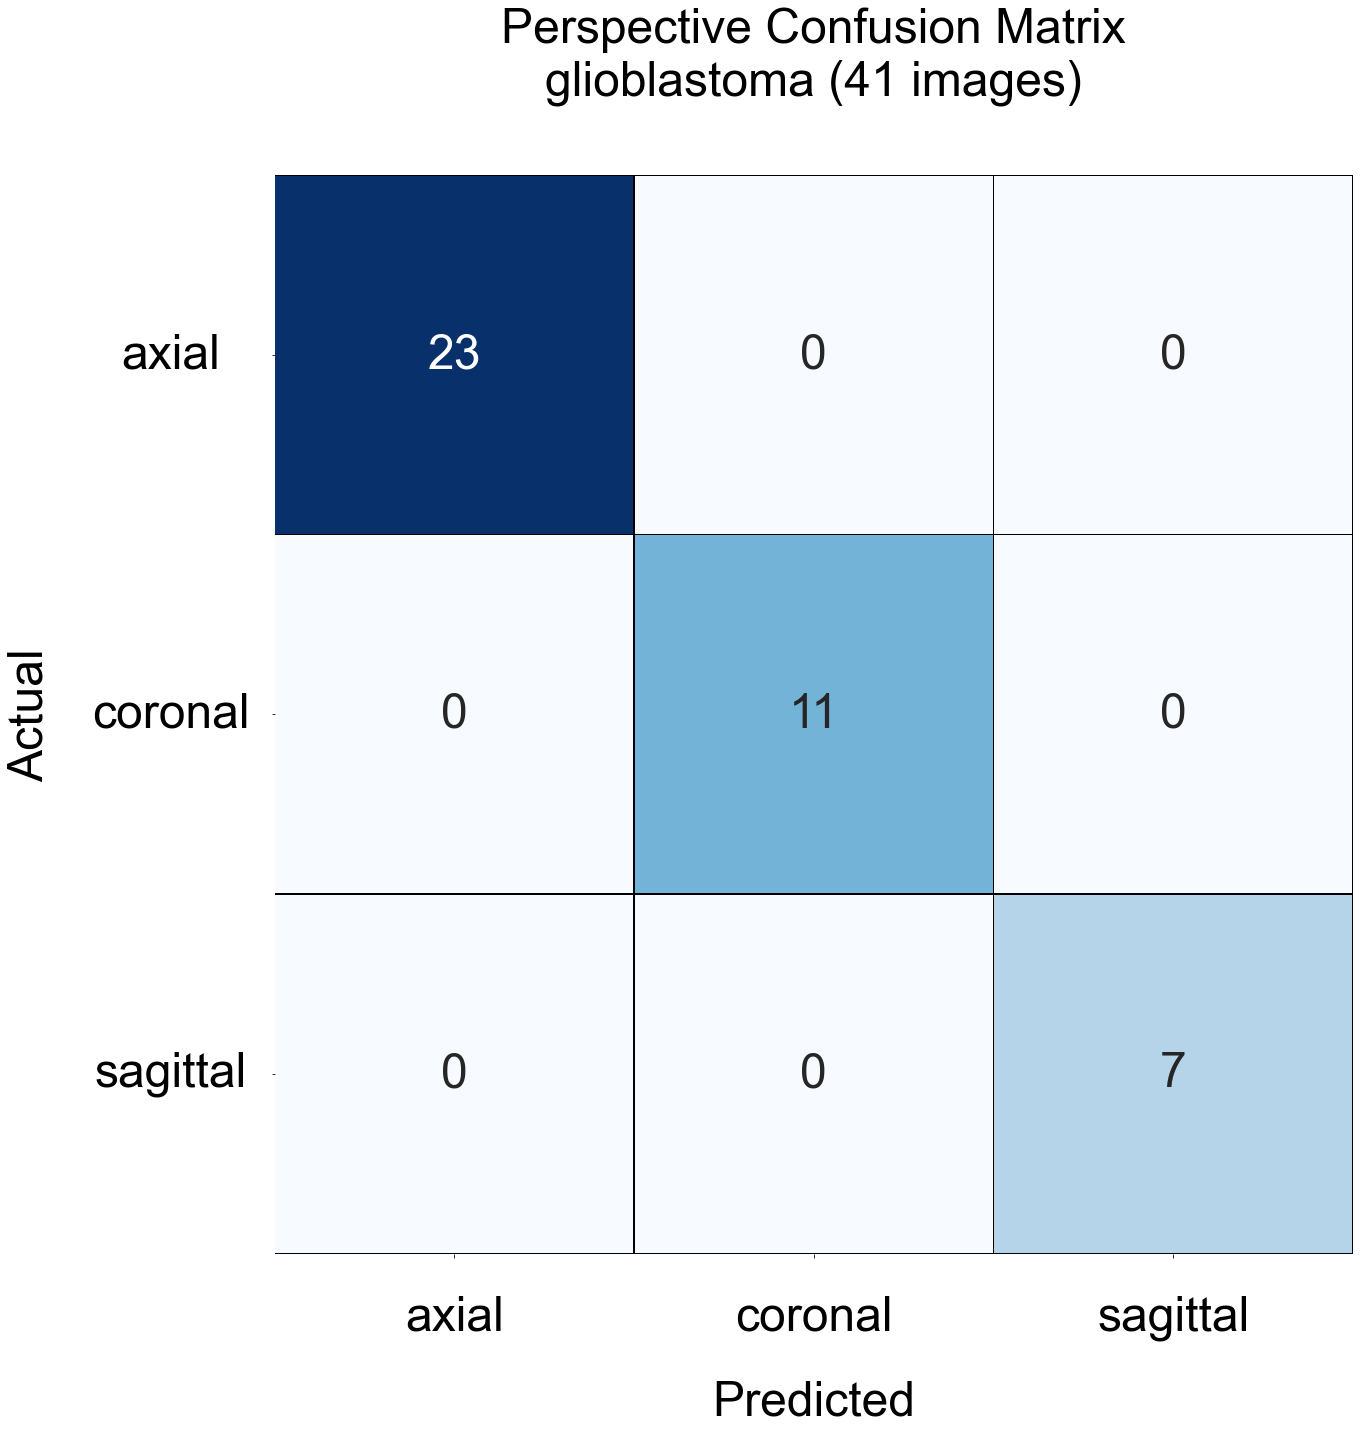

In [12]:
long_labels = ['axial', 'coronal', 'sagittal']

ev.plot_cm(
    test_df,
    labels,
    long_labels,
    'glioblastoma',
    label_type
)

## GradCAM Images

Plot GradCAM heatmap for a selection of correctly classified images

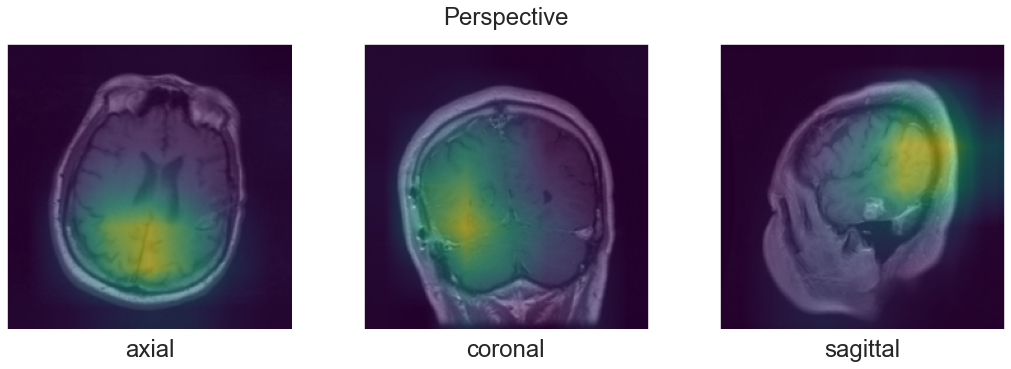

In [13]:
selected_images = [
'AX_T1_Glioma_GBM_TCGA061084_1.jpg', 
'COR_T1KM_Glioma_GBM_TCGA020102_1.jpg',
'SAG_T1KM_Glioma_GBM_TCGA020060_2.jpg'
]

img_list = [os.path.join(images_dir, img) for img in selected_images]
# print(img_list)

actuals = ['AX', 'COR', 'SAG']

heatmaps = ev.get_heatmaps(
    img_list=img_list,
    model=model,
    y_true=actuals,
    y_pred=actuals,
    classifier_layer_names = ['global_average_pooling2d', 'dropout', 'dense'],
    last_conv_layer_name='functional_1'
)

ev.plot_gradcam_image(heatmaps)